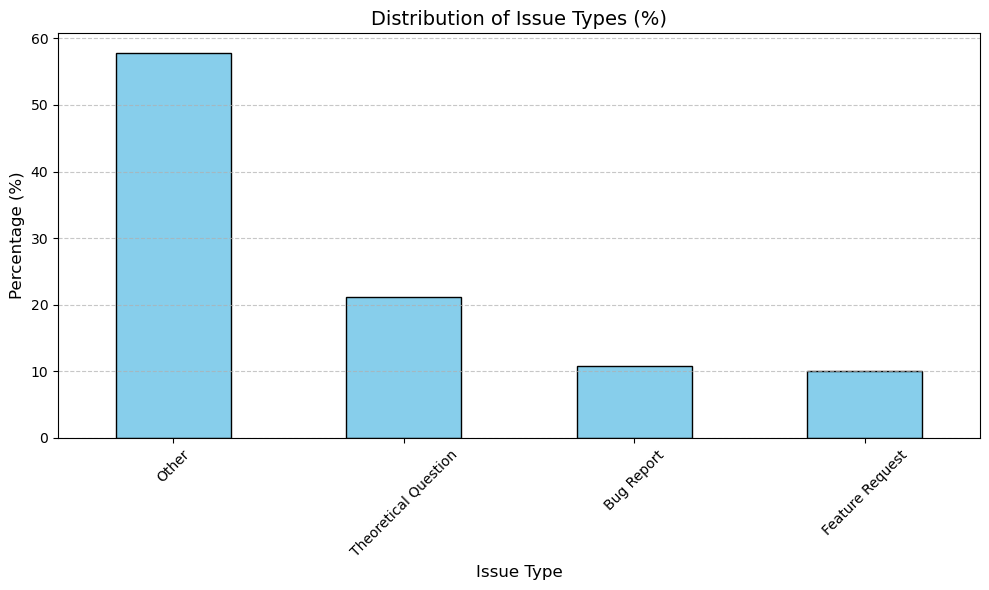

Issue types have been classified and saved to 'classified_conversations.csv'.


In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re

# Load the dataset
# Ensure the merged dataset (merged_conversations.csv) is in the same directory as the script.
data = pd.read_csv('merged_conversations.csv')

# Fill missing values in the 'Prompt' column and ensure it is in string format
# This avoids issues when processing textual data with missing entries.
data['Prompt'] = data['Prompt'].fillna('').astype(str)

# Define a function to classify issues based on keywords in the prompt
def classify_issue(prompt):
    """
    Classifies a developer's prompt into one of four categories:
    1. Bug Report: Indicates a technical issue or error.
    2. Feature Request: Suggests adding or improving a feature.
    3. Theoretical Question: Asks a question or seeks conceptual help.
    4. Other: Prompts that do not fit into the above categories.

    Parameters:
    prompt (str): The developer's input prompt to ChatGPT.

    Returns:
    str: The classified issue type.
    """
    # Convert the prompt to lowercase for case-insensitive keyword matching
    prompt = prompt.lower()
    
    # Match keywords to classify the issue type
    if any(keyword in prompt for keyword in ['bug', 'error', 'crash', 'fix', 'fail']):
        return 'Bug Report'
    elif any(keyword in prompt for keyword in ['feature', 'enhance', 'add', 'implement', 'improve']):
        return 'Feature Request'
    elif 'how to' in prompt or '?' in prompt:
        return 'Theoretical Question'
    else:
        return 'Other'

# Apply the classification function to the dataset
# This creates a new column 'IssueType' containing the issue categories.
data['IssueType'] = data['Prompt'].apply(classify_issue)

# Calculate the distribution of issue types
# Normalize=True calculates the percentages of each type instead of raw counts.
issue_counts = data['IssueType'].value_counts(normalize=True) * 100

# Plot the distribution of issue types
# The bar chart visualizes the proportion of each issue type in the dataset.
plt.figure(figsize=(10, 6))
issue_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Issue Types (%)', fontsize=14)
plt.xlabel('Issue Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

# Save the results to a new CSV file
# This file will include the original dataset along with the 'IssueType' column.
data.to_csv('classified_conversations.csv', index=False, encoding='utf-8-sig')

# Print a confirmation message
print("Issue types have been classified and saved to 'classified_conversations.csv'.")


Most common patterns in prompts:
[('string', 21073), ('you', 12630), ('name', 11768), ('with', 11537), ('1', 8735), ('0', 8639), ('from', 8058), ('s', 7300), ('if', 6811), ('as', 6492), ('are', 5767), ('by', 5737), ('can', 5435), ('item', 5429), ('your', 5402), ('not', 5270), ('be', 5245), ('passage', 5036), ('we', 4819), ('2', 4812)]


<Figure size 1000x600 with 0 Axes>

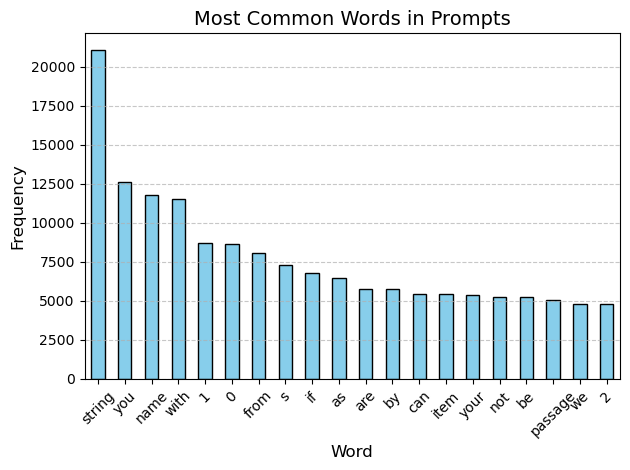

Patterns most correlated with resolution:
Resolved    1.000000
new         0.013154
if          0.011805
text        0.010419
have        0.010229
we          0.009718
are         0.009623
data        0.009122
what        0.008757
user        0.008512
Name: Resolved, dtype: float64


<Figure size 1000x600 with 0 Axes>

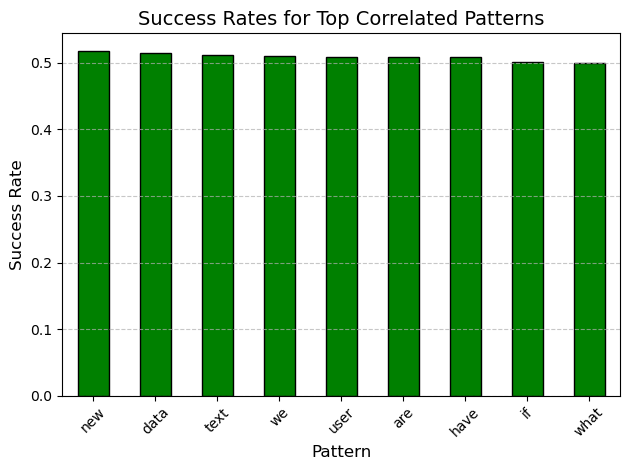

In [2]:
# Importing required libraries
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to preprocess prompts
def preprocess_prompt(prompt):
    """
    Preprocesses a given prompt by:
    - Tokenizing the text into individual words.
    - Converting all text to lowercase.
    - Removing stop words (common words with little meaning).

    Parameters:
    prompt (str): The input prompt string.

    Returns:
    list: A list of meaningful words extracted from the prompt.
    """
    # Tokenize the text (extract words)
    tokens = re.findall(r'\b\w+\b', str(prompt).lower())

    # Define a set of common stop words to exclude
    stop_words = set(["i", "am", "is", "the", "and", "or", "on", "a", "an", "of", "to", "in", "for", "this", "that", "it"])
    
    # Filter out stop words from the tokens
    return [word for word in tokens if word not in stop_words]

# Apply preprocessing to the 'Prompt' column in the dataset
# Ensure the 'Prompt' column is filled and processed
data['ProcessedPrompt'] = data['Prompt'].fillna('').apply(preprocess_prompt)

# Flatten the processed words into a single list and count occurrences
all_words = [word for words in data['ProcessedPrompt'] for word in words]
word_counts = Counter(all_words)

# Display the top 20 most common patterns in prompts
print("Most common patterns in prompts:")
print(word_counts.most_common(20))

# Convert the most common words into a DataFrame for visualization
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Plot the top 20 most common words
plt.figure(figsize=(10, 6))
common_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False, color='skyblue', edgecolor='black')
plt.title('Most Common Words in Prompts', fontsize=14)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Convert the processed prompts back to a single string for vectorization
data['ProcessedPromptString'] = data['ProcessedPrompt'].apply(lambda x: ' '.join(x))

# Use CountVectorizer to extract the 50 most common features (words)
vectorizer = CountVectorizer(max_features=50)
X = vectorizer.fit_transform(data['ProcessedPromptString'])

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store word frequencies for each prompt
word_frequencies = pd.DataFrame(X.toarray(), columns=feature_names)

# Add the 'Resolved' column to analyze correlation with patterns
if 'Resolved' in data.columns:
    word_frequencies['Resolved'] = data['Resolved']
else:
    # Generate a synthetic 'Resolved' column for testing (alternating 1 and 0)
    word_frequencies['Resolved'] = [1 if i % 2 == 0 else 0 for i in range(len(word_frequencies))]

# Calculate correlations between patterns and the 'Resolved' column
correlations = word_frequencies.corr()['Resolved'].sort_values(ascending=False)
print("Patterns most correlated with resolution:")
print(correlations.head(10))

# Extract the top 10 patterns most correlated with resolution
top_patterns = correlations.head(10).index

# Calculate success rates for the top patterns
success_rates = {}
for pattern in top_patterns:
    if pattern != 'Resolved':  # Exclude the 'Resolved' column
        success_rates[pattern] = word_frequencies[word_frequencies[pattern] > 0]['Resolved'].mean()

# Convert success rates into a DataFrame for visualization
success_rates_df = pd.DataFrame.from_dict(success_rates, orient='index', columns=['Success Rate'])

# Plot success rates for the top correlated patterns
plt.figure(figsize=(10, 6))
success_rates_df.sort_values(by='Success Rate', ascending=False).plot(kind='bar', legend=False, color='green', edgecolor='black')
plt.title('Success Rates for Top Correlated Patterns', fontsize=14)
plt.xlabel('Pattern', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
